# Working with final df to scale everything.

In [155]:
import pandas as pd
from path import Path

import requests
import pprint
import requests
from requests.exceptions import HTTPError
from datetime import datetime as dt
import pandas as pd
import numpy as np
import timeit
import time
import datetime
import copy

import numpy as np
from sklearn import preprocessing
%matplotlib inline

import pandas as pd
from path import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

import plotly.express as px

In [33]:
file_path = Path("../../../../data/cleandata/success_df.csv")

In [34]:
success_df = pd.read_csv(file_path)

In [200]:
success_df.head(8)

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,compound,negative,neutral,positive,no_of_posts,Longevity
1,7,3277372658,21.07,231846713,-0.46,-1.33,2.49,0.0,20,0.563773,0.096670,0.041410,0.861890,100,848
2,8,3214893394,3.42,1735988258,0.11,-1.49,-2.55,4.6,350,0.828470,0.032200,0.858550,0.109270,100,522
3,13,1105888653,0.042654,53437224,-0.50,-1.72,-2.12,0.0,488,0.589474,0.098387,0.032946,0.868753,93,1049
4,16,913746412,3.79,252881495,-0.27,-1.89,-4.79,2.8,0,0.525717,0.081630,0.033480,0.884940,100,779
5,18,821746518,1.24,44390717,-0.25,10.13,2.47,4.3,13,0.663939,0.021939,0.878857,0.099327,49,855
6,19,760265147,3.99,147439544,-1.62,1.29,2.14,4.3,0,0.340496,0.060687,0.023224,0.916194,67,954
7,22,632251075,69.07,346367843,-0.12,-1.18,-5.06,0.0,0,0.663146,0.102770,0.025100,0.872110,100,779
8,23,547458892,4.76,642121534,-0.20,-2.10,-9.16,1.1,0,0.377329,0.079930,0.037850,0.882180,100,779


# drop unncessary columns and scale all

In [36]:
success_df.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'price', 'volume24',
       'pct1h', 'pct24h', 'pct7d', 'country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'rating', 'status', 'type', 'End', 'Start', 'Duration',
       'pre_Duration', 'compound', 'negative', 'neutral', 'positive',
       'no_of_posts', 'Longevity', 'custom_index', 'custom_index_scaled',
       'success'],
      dtype='object')

In [37]:
success_df.drop(columns = ['Name', 'Ticker','country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'status', 'type', 'pre_Duration','custom_index',
       'custom_index_scaled', 'success', 'End', 'Start'], inplace = True)

In [43]:
success_df['Duration'][1][:-23]

'20 '

In [49]:
def removing_days(df):
    
    for i in range(len(df)) : 
        df.loc[i, "Duration"] = df.loc[i, "Duration"][:-23]
    return df

In [50]:
removing_days(success_df)

In [56]:
success_df.dtypes

In [57]:
success_df.head(1)

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,compound,negative,neutral,positive,no_of_posts,Longevity
0,2,"20,155,411,771",185.67,"7,906,136,399",-0.1,-1.2,-0.96,0.0,0,0.46057,0.06116,0.02739,0.90151,100,779


In [76]:
success_df.replace("1,284.19","0", inplace=True)

success_df.replace("-126 d","-126", inplace=True)

In [173]:
success_df = success_df.iloc[1:]

### Start PCA

In [182]:
success_scaled = StandardScaler().fit_transform(success_df)

In [183]:
pca = PCA(n_components=3)

In [184]:
success_pca = pca.fit_transform(success_scaled)

In [185]:
# Transform PCA data to a DataFrame
df_success_pca = pd.DataFrame(
    data=success_pca, columns=["principal component 1", "principal component 2", 'principal component 3'])
df_success_pca.head()

,principal component 1,principal component 2,principal component 3
0,6.323877,12.660679,1.877663
1,5.579395,19.324035,14.756054
2,3.843003,5.100828,3.311398
3,3.104689,4.599435,0.549920
4,-0.642963,3.506664,0.386545


In [186]:
pca.explained_variance_ratio_.sum() #horrible but 3 what we need according to the elbow curve

0.42378485165428187

In [187]:
# Finding the best value for k
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_success_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [198]:
# Predicting clusters with k=3 USED 3 there is an outlier.... 

# Initialize the K-Means model
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(df_success_pca)

# Predict clusters
predictions = model.predict(df_success_pca)

# Add the predicted class columns
df_success_pca["class"] = model.labels_
df_success_pca[df_success_pca['class'] == 2]

,principal component 1,principal component 2,principal component 3,class
0,6.323877,12.660679,1.877663,2
1,5.579395,19.324035,14.756054,2
2,3.843003,5.100828,3.311398,2
6,6.233977,10.450669,-2.029469,2
7,3.679175,6.505977,0.999637,2


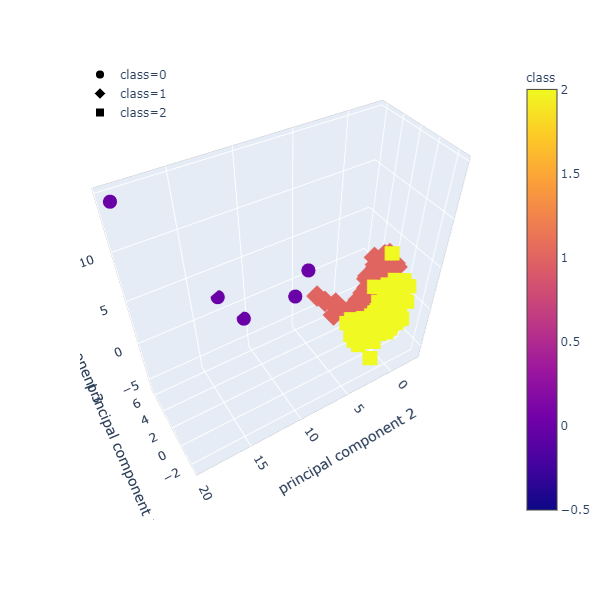

In [189]:
fig = px.scatter_3d(
    df_success_pca,
    x="principal component 1",
    y="principal component 2",
    z="principal component 3",
    color="class",
    symbol="class",
    #size="sepal_width",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

### Outlier removed. The highest market cap was causing this model to fail with a huge outlier.
### Removed. What is shown is now more telling.

In [337]:
success_df_pca_class_2 = pd.read_csv(file_path)

In [338]:
success_df_pca_class_2['success_PCA'] = 0

In [339]:
success_df_pca_class_2.at[[0,1,2,6,7],'success_PCA']=1

In [340]:
success_df_pca_class_2.iloc[[0,1,2,6,7]]['success_PCA'] 

0    1
1    1
2    1
6    1
7    1
Name: success_PCA, dtype: int64

In [341]:
success_df_pca_class_2.rename(columns = {'success':'success_index'}, inplace = True)

In [342]:
success_df_pca_class_2.head(2)

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,compound,negative,neutral,positive,no_of_posts,Longevity,custom_index,custom_index_scaled,success_index,success_PCA
0,7,Binance Coin,BNB,3277372658,21.07,231846713,-0.46,-1.33,2.49,Japan,...,0.563773,0.09667,0.04141,0.86189,100,848,17867.36,0.015956,1,1
1,8,EOS,EOS,3214893394,3.42,1735988258,0.11,-1.49,-2.55,Cayman Islands,...,0.828470,0.03220,0.85855,0.10927,100,522,1785.24,0.001594,0,1


In [347]:
success_df.head(2)

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,compound,negative,neutral,positive,no_of_posts,Longevity
1,7,3277372658,21.07,231846713,-0.46,-1.33,2.49,0.0,20,0.563773,0.09667,0.04141,0.86189,100,848
2,8,3214893394,3.42,1735988258,0.11,-1.49,-2.55,4.6,350,0.828470,0.03220,0.85855,0.10927,100,522


In [344]:
success_df_pca_class_2.replace("1,284.19","0", inplace=True)

success_df_pca_class_2.replace("-126 d","-126", inplace=True)

In [334]:
success_df_pca_class_2 = success_df_pca_class_2.iloc[1:]

In [348]:
success_df_pca_class_2.shape

(572, 30)

In [349]:
success_df.shape

(572, 15)

In [352]:
a = set(success_df_pca_class_2['rank_cnc']) 
b = set(success_df['rank_cnc'])
c=(a^b)&b
d=(a^b)&a

In [354]:
d

set()

In [355]:
c

set()

In [264]:
def check_what_matches(df1,df2):
    duplicates = []
    
    for ticker1 in df1['rank_cnc'].tolist():
        for ticker2 in df2['rank_cnc'].tolist():
            if ticker1 != ticker2:
                duplicates.append(ticker1)
            else:
                continue
    return duplicates

In [273]:
# check_what_matches(success_df, success_df_pca_class_2)

In [356]:
#doing it manually.... iterations were not working at all... :\
success_df.columns

Index(['rank_cnc', 'market_cap', 'price', 'volume24', 'pct1h', 'pct24h',
       'pct7d', 'rating', 'Duration', 'compound', 'negative', 'neutral',
       'positive', 'no_of_posts', 'Longevity'],
      dtype='object')

In [357]:
success_df_pca_class_2.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'price', 'volume24',
       'pct1h', 'pct24h', 'pct7d', 'country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'rating', 'status', 'type', 'End', 'Start', 'Duration',
       'pre_Duration', 'compound', 'negative', 'neutral', 'positive',
       'no_of_posts', 'Longevity', 'custom_index', 'custom_index_scaled',
       'success_index', 'success_PCA'],
      dtype='object')

In [358]:
for columns in list(success_df.columns):
    success_df_pca_class_2[columns] = success_df[columns]

In [359]:
success_df_pca_class_2.index[success_df_pca_class_2['success_PCA'] == 1].tolist()

In [365]:
success_df_pca_class_2 = success_df_pca_class_2[1:]

In [366]:
file_path = Path("../../../../data/cleandata/success_PCA_df.csv")
success_df_pca_class_2.to_csv(file_path, index=False)